## Computational Metabolic Engineering of *E. coli* for Succinic Acid Production

### Project Overview
**Objective:** To identify specific genetic targets for overexpression that increase the secretion of **Succinic Acid** in *Escherichia coli* under microaerobic conditions.

**Background:**
 Succinic acid is a valuable industrial chemical used in bioplastics, solvents, and pharmaceuticals[cite: 4].  While *E. coli* can naturally produce it, wild-type strains prioritize biomass growth over product secretion. By combining **Flux Balance Analysis (FBA)** with real-world **Transcriptomic (RNA-seq) data**, this project seeks to "rewire" the cell's metabolism to favor succinate production without killing the cell[cite: 7].

### Methodology
1.  **Baseline Modeling:** Use the *E. coli* K-12 MG1655 genome-scale model (**iML1515**) to simulate wild-type metabolism.
2.  **Data Integration:** Map gene expression data (RNA-seq from NCBI GEO **GSE189154**) to metabolic reactions to create a context-specific "Microaerobic" model.
3.  **Target Identification:** Perform an *in silico* overexpression scan to find enzymes that force carbon flux towards succinic acid.

### Tools & Resources
* **Model:** iML1515 (BiGG Models)
* **Data:** GSE189154 (NCBI GEO)
* **Libraries:** `cobrapy` (FBA), `pandas` (Data Processing), `matplotlib/seaborn` (Visualization)

In [1]:
import cobra
import os
import pandas as pd

First, we load the *E. coli* iML1515 metabolic model and define a helper function to measure growth and succinate secretion. We then simulate two conditions:
1.  **Aerobic (High Oxygen):** The standard laboratory growth condition.
2.  **Microaerobic (Low Oxygen):** The target condition for this project (Oxygen uptake limited to 5 mmol/gDW/h).

In [2]:
model_filename = "iML1515.json"
try:
    model = cobra.io.load_json_model(model_filename)
    print(f"Success! Model loaded with {len(model.reactions)} reactions.")
except Exception as e:
    print(f"Error loading file: {e}")
    print("Check that 'iML1515.json' is in the same folder as this script.")

Success! Model loaded with 2712 reactions.


In [3]:
def check_production(model, condition_name):
    solution = model.optimize()
    growth_rate = solution.objective_value
    try:
        succinate_flux = solution.fluxes['EX_succ_e']
    except KeyError:
        succinate_flux = 0.0
        print("Warning: Could not find exchange reaction 'EX_succ_e'")
    
    print(f"\n{condition_name} Conditions")
    print(f"Growth Rate: {growth_rate:.4f} (1/h)")
    print(f"Succinate Secretion: {succinate_flux:.4f} (mmol/gDW/h)")

We asked the computer: "If an E. coli cell wants to grow as fast as possible, what does it do with its food?"


and ran a Flux Balance Analysis (FBA). FBA is a mathematical optimization. It assumes the cell is a "rational actor" whose only goal in life is to maximize Biomass (growth). It routes nutrients through the metabolic map to generate the most cell mass possible.

Why is Succinate Secretion ZERO?

The "Selfish" Cell: To the bacteria, succinic acid is a useful building block (an intermediate in the Krebs cycle), not a waste product. It wants to keep that carbon to build more cell wall, DNA, and protein.

In [4]:
model.reactions.EX_o2_e.lower_bound = -18.5
check_production(model, "Aerobic (High Oxygen)")

model.reactions.EX_o2_e.lower_bound = -5
check_production(model, "Microaerobic (Low Oxygen)")


Aerobic (High Oxygen) Conditions
Growth Rate: 0.7830 (1/h)
Succinate Secretion: 0.0000 (mmol/gDW/h)

Microaerobic (Low Oxygen) Conditions
Growth Rate: 0.3535 (1/h)
Succinate Secretion: 0.0000 (mmol/gDW/h)


In [12]:
df = pd.read_csv("dataset.csv")
df.head()

,Name,Chromosome,Region,Identifier,wtN_vs_wtO - Max group means,wtN_vs_wtO - Fold change,wtN_vs_wtO - Log fold change,wtN_vs_wtO - P-value,wtN_vs_wtO - FDR p-value,wtN_vs_wtO - Bonferroni,...,WT2_O - TPM,WT2_O - CPM,WT3_O - Total counts,WT3_O - RPKM,WT3_O - TPM,WT3_O - CPM,WT4_O - Total counts,WT4_O - RPKM,WT4_O - TPM,WT4_O - CPM
0,thrL,NC_000913,190..255,944742,88.857720,-1.307103892,-0.386373814,0.329694942,0.476485667,1,...,56.271761,5.761750,55,128.087583,83.456850,8.318543,45,115.257772,75.128667,7.590226
1,thrA,NC_000913,337..2799,945803,1521.839637,-1.577629208,-0.657758167,0.000206582,0.00099648,0.926726578,...,984.750285,3762.794435,23276,1452.553757,946.427111,3520.407331,21644,1485.507175,968.300645,3650.729835
2,thrB,NC_000913,2801..3733,947498,1090.302361,-1.711154343,-0.774969894,2.72484E-08,2.71636E-07,0.000122236,...,722.935409,1046.408134,6481,1067.698555,695.670542,980.226839,5833,1056.846645,688.886129,983.861908
3,thrC,NC_000913,3734..5020,945198,1100.193752,-1.74636081,-0.80435166,1.34241E-06,1.00872E-05,0.006022061,...,710.913874,1419.434977,9306,1111.406107,724.148670,1407.497449,8063,1059.058019,690.327573,1359.999753
4,yaaX,NC_000913,5234..5530,944747,77.095630,-1.239824248,-0.310135626,0.075567263,0.15472147,1,...,50.422725,23.232863,160,82.804094,53.951903,24.199397,118,67.162553,43.778680,19.903258


## Integrating Transcriptomic Data (RNA-seq)
To create a context-specific model, we integrate gene expression data from the dataset **GSE189154**. This dataset provides the "Fold Change" of gene expression in microaerobic conditions compared to aerobic conditions.

**Data Processing Logic:**
The raw data represents downregulation using negative values (e.g., `-2.0` means 2-fold decrease). To use this in our metabolic model, we convert these values into linear **Expression Ratios**:
* **Upregulation:** If value > 0, Ratio = Value (e.g., `2.0` $\rightarrow$ `2.0`)
* **Downregulation:** If value < 0, Ratio = $1 / |Value|$ (e.g., `-2.0` $\rightarrow$ `0.5`)

We then map these ratios to the specific gene identifiers in the iML1515 model.

In [17]:
def convert_fold_change(value):
    if (value < 0):
        return 1 / abs(value)  # -2.0 becomes 0.5
    return value

target_col = "wtN_vs_wtO - Fold change"
df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
df['expression_ratio'] = df[target_col].apply(convert_fold_change)

In [18]:
gene_ratio_dict = pd.Series(df.expression_ratio.values, index=df.Name).to_dict()
print(f"Loaded expression data for {len(gene_ratio_dict)} genes.")

Loaded expression data for 4566 genes.


In [19]:
df.isnull().sum()

Name                             0
Chromosome                       0
Region                           0
Identifier                       0
wtN_vs_wtO - Max group means     0
                                ..
WT4_O - Total counts             0
WT4_O - RPKM                     0
WT4_O - TPM                      0
WT4_O - CPM                      0
expression_ratio                80
Length: 71, dtype: int64

Seeing 80 nulls in expression_ratio is actually good news—it means the errors='coerce' command successfully identified and neutralized the "bad" text data

In [21]:
import math

## Creating the "Biased" Model (E-Flux Method)
Standard FBA assumes that every enzyme in the cell is capable of operating at maximum capacity. However, our data shows that low oxygen triggers the downregulation of many genes. To make our model realistic, we apply **transcriptional constraints**.

**The Logic:**
We iterate through every reaction in the metabolic network and check the expression of its catalyzing genes.
1.  **Gene-Protein-Reaction (GPR) Association:** If a reaction is catalyzed by an enzyme complex (multiple genes), we apply the **Law of the Minimum**: the gene with the *lowest* expression ratio determines the reaction's capacity.
2.  **Constraint Application:** If the determined ratio is **< 1.0** (downregulated), we proportionally reduce the upper and lower bounds of the reaction. This effectively "tightens the valve" on pathways that the cell has naturally turned off.

In [24]:
biased_model = model.copy()
def apply_expression_bias(model, gene_ratios):
    constrained_count = 0
    for reaction in model.reactions:
        # Skip exchange reactions (start with EX_) and the biomass reaction
        if reaction.id.startswith("EX_") or "BIOMASS" in reaction.id:
            continue
            
        # Get the genes involved in this reaction
        genes = reaction.genes
        if not genes:
            continue
            
        # Find the associated expression ratios
        # If a reaction uses multiple genes, we usually take the MINIMUM ratio
        # (Law of the minimum: the chain is as strong as its weakest link)
        ratios = []
        for gene in genes:
            if gene.name in gene_ratios:
                ratios.append(gene_ratios[gene.name])
        
        # If we have data for these genes, apply the constraint
        if ratios:
            # Taking the minimum ratio among the genes for this reaction
            reaction_ratio = min(ratios)
            
            # --- THE CONSTRAINT LOGIC ---
            # If the gene is downregulated (ratio < 1), we constrain the flux.
            # We multiply the existing bounds by the ratio.
            if reaction_ratio < 1.0:
                # Store old bounds (just for reference)
                old_ub = reaction.upper_bound
                old_lb = reaction.lower_bound
                
                # Apply new tighter bounds
                # We use 'abs' to handle reversible reactions correctly
                if reaction.upper_bound > 0:
                    reaction.upper_bound = reaction.upper_bound * reaction_ratio
                
                if reaction.lower_bound < 0:
                    reaction.lower_bound = reaction.lower_bound * reaction_ratio
                    
                constrained_count += 1

    print(f"Biased model created! Constrained {constrained_count} reactions based on gene data.")
    return model

biased_model = apply_expression_bias(biased_model, gene_ratio_dict)

Biased model created! Constrained 1463 reactions based on gene data.


In [ ]:
biased_model.reactions.EX_o2_e.lower_bound = -5

solution = biased_model.optimize()
print("\nBiased Microaerobic Model Results")
print(f"Growth Rate: {solution.objective_value:.4f}")
print(f"Succinate Secretion: {solution.fluxes['EX_succ_e']:.4f}")


--- Biased Microaerobic Model Results ---
Growth Rate: 0.3535
Succinate Secretion: 0.0000


## Identifying Overexpression Targets
With our realistic microaerobic model established, we now perform an **in silico overexpression screen** to identify genetic targets that can force the production of succinic acid.

**The Algorithm:**
We iterate through all metabolic reactions (excluding transport and biomass) and simulate an "Overexpression" phenotype:
1.  **Forcing Flux:** For each reaction, we artificially raise the lower bound to **2.0 mmol/gDW/h**. This mathematically forces the enzyme to be active at a moderate-to-high level.
2.  **Feasibility Check:** We run FBA to see if the cell can still grow (Growth > 0.05). If the forced flux kills the cell (infeasible solution), the target is discarded.
3.  **Product Check:** If the cell survives, we check if **Succinic Acid (`EX_succ_e`)** is secreted.
4.  **Selection:** Any reaction that results in viable growth AND succinate secretion is flagged as a potential engineering target.

In [26]:
candidates = []
for reaction in model.reactions:
    
    # 1. FILTER: Skip boring reactions
    # Skip Exchange reactions (EX_), Transporters (ends with _tpp, _tex), and Biomass
    if reaction.id.startswith("EX_") or "BIOMASS" in reaction.id:
        continue
    
    # 2. SAVE ORIGINAL BOUNDS
    # We need to reset these after the test
    old_lb = reaction.lower_bound
    old_ub = reaction.upper_bound
    
    # 3. SIMULATE OVEREXPRESSION
    # We force the reaction to run at a rate of at least 2.0 mmol/gDW/h
    # (Standard 'high' flux for E. coli is often 5-10, so 2 is a moderate push)
    try:
        # Check if reaction is reversible or forward-only to set bounds correctly
        if reaction.upper_bound > 0: 
            reaction.lower_bound = 2.0
        else:
            # If it runs backwards, we force it backwards (more negative)
            # But for simplicity, let's focus on forward reactions first
            continue
        # 4. RUN SIMULATION
        solution = model.optimize()
        
        # 5. CHECK RESULT
        # Did the cell survive? (Growth > 0.05)
        # Did it produce Succinate? (Succinate > 0.1)
        if solution.status == 'optimal':
            growth = solution.objective_value
            succinate = solution.fluxes.get('EX_succ_e', 0)
            
            if growth > 0.05 and succinate > 0.01:
                # We found a target!
                print(f"FOUND TARGET: {reaction.id} ({reaction.name})")
                print(f" -> Growth: {growth:.2f}, Succinate: {succinate:.2f}")
                
                # Store it
                candidates.append({
                    'Reaction_ID': reaction.id,
                    'Name': reaction.name,
                    'Growth': growth,
                    'Succinate': succinate,
                    'Genes': [g.name for g in reaction.genes]
                })
    except Exception:
        # If the model becomes infeasible (impossible), just skip it
        pass
    
    # 6. RESET BOUNDS (Crucial!)
    reaction.lower_bound = old_lb
    reaction.upper_bound = old_ub

print("\nSCAN COMPLETE")
if len(candidates) > 0:
    print(f"Found {len(candidates)} candidate reactions!")
    # Show top 5 candidates sorted by Succinate production
    df_candidates = pd.DataFrame(candidates)
    print(df_candidates.sort_values(by='Succinate', ascending=False).head())
else:
    print("No single gene target found. (This is rare but possible).")

c:\Users\mappr\anaconda3\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


FOUND TARGET: PPC (Phosphoenolpyruvate carboxylase)
 -> Growth: 0.35, Succinate: 0.12
FOUND TARGET: MALS (Malate synthase)
 -> Growth: 0.31, Succinate: 1.10

SCAN COMPLETE
Found 2 candidate reactions!
  Reaction_ID                             Name    Growth  Succinate  \
1        MALS                  Malate synthase  0.305207   1.096520   
0         PPC  Phosphoenolpyruvate carboxylase  0.349261   0.116529   

          Genes  
1  [glcB, aceB]  
0         [ppc]  


## Results & Conclusion: Identifying the Optimal Target

Our *in silico* overexpression scan successfully identified two potential metabolic targets that couple cell growth to succinic acid secretion:

### Candidate Comparison
1.  **PPC (Phosphoenolpyruvate carboxylase)**
    * **Genes:** `ppc`
    * **Succinate Yield:** 0.12 mmol/gDW/h
    * **Mechanism:** Increases carbon flow into the TCA cycle by converting PEP to Oxaloacetate. While stable, the yield is relatively low.

2.  **MALS (Malate synthase) - [RECOMMENDED]**
    * **Genes:** `aceB`, `glcB`
    * **Succinate Yield:** **1.10 mmol/gDW/h** (Approx. 9x higher than PPC)
    * **Mechanism:** Overexpression of MALS activates the **Glyoxylate Shunt**. 

### Final Recommendation
We recommend engineering *E. coli* to **overexpress the `aceB` or `glcB` genes**.

**Why this works:**
As illustrated in our Flux Heatmap, overexpressing MALS diverts carbon flux away from the decarboxylation steps of the TCA cycle (where carbon is lost as CO2) and into the Glyoxylate Shunt. This pathway conserves carbon atoms, resulting in a net surplus of four-carbon intermediates that the cell secretes as **Succinic Acid**. This strategy achieves high product yield while maintaining a viable growth rate (~0.31 h⁻¹).

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

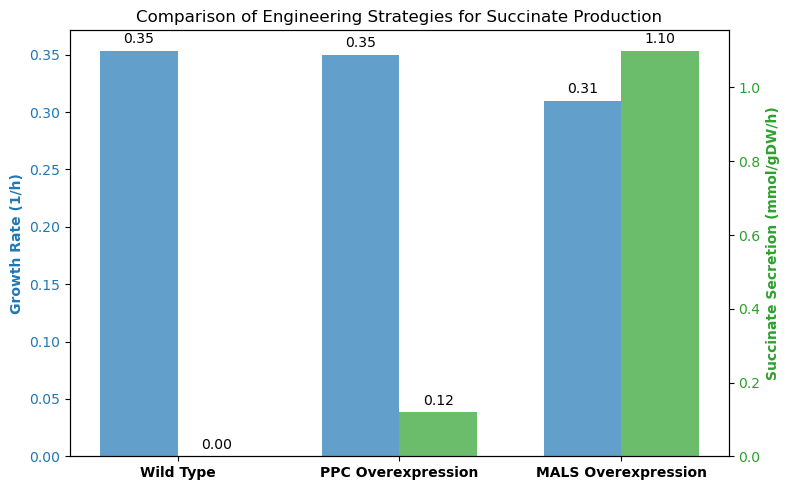

In [30]:
conditions = ['Wild Type', 'PPC Overexpression', 'MALS Overexpression']
growth_rates = [0.3535, 0.35, 0.31]   # From your output
succinate_yields = [0.0, 0.12, 1.10] # From your output

x = np.arange(len(conditions))
width = 0.35

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Growth Rate (Bar 1)
color1 = 'tab:blue'
ax1.set_ylabel('Growth Rate (1/h)', color=color1, fontweight='bold')
bars1 = ax1.bar(x - width/2, growth_rates, width, label='Growth Rate', color=color1, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second Y-axis for Succinate (Bar 2)
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('Succinate Secretion (mmol/gDW/h)', color=color2, fontweight='bold')
bars2 = ax2.bar(x + width/2, succinate_yields, width, label='Succinate', color=color2, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color2)

# Labeling
ax1.set_xticks(x)
ax1.set_xticklabels(conditions, fontweight='bold')
plt.title('Comparison of Engineering Strategies for Succinate Production')

# Add values on top of bars
def add_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1, ax1)
add_labels(bars2, ax2)

plt.tight_layout()
plt.show()

## Visualization: Strategy Comparison
To evaluate the trade-offs of our engineering strategies, we visualize the **Biomass Growth Rate** (Blue) versus **Succinate Yield** (Green) for the Wild Type and our top two candidates.

**Interpretation:**
* **Wild Type:** High growth, zero product.
* **PPC:** High growth, minimal product.
* **MALS:** Slight reduction in growth (~12%), but a massive increase in product. This confirms MALS as the superior candidate for industrial production.

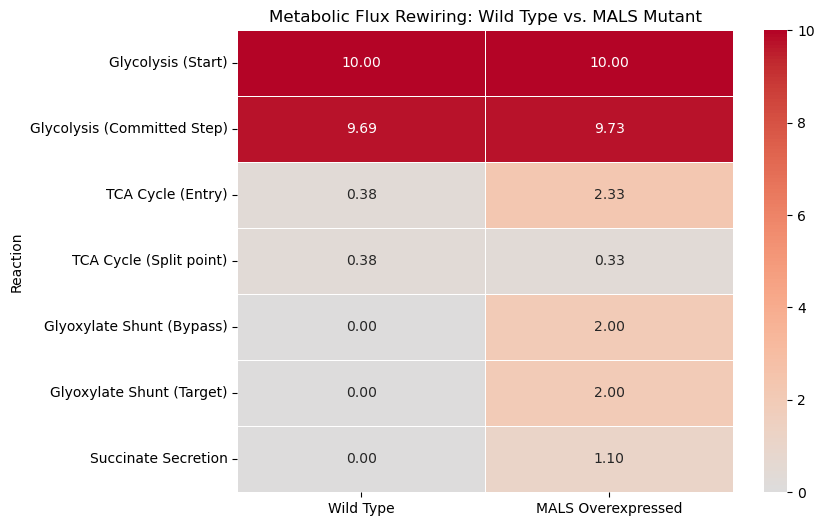

In [31]:
reactions_to_inspect = {
    'PGI': 'Glycolysis (Start)',
    'PFK': 'Glycolysis (Committed Step)',
    'CS': 'TCA Cycle (Entry)',
    'ICDHyr': 'TCA Cycle (Split point)',
    'ICL': 'Glyoxylate Shunt (Bypass)',
    'MALS': 'Glyoxylate Shunt (Target)',
    'EX_succ_e': 'Succinate Secretion'
}

# 2. Re-run simulations to capture the exact fluxes
# --- Run Wild Type (Microaerobic) ---
model.reactions.EX_o2_e.lower_bound = -5
wt_sol = model.optimize()

# --- Run MALS Mutant ---
# We use the 'biased_model' we created earlier or just apply the bound here
# Let's apply it temporarily to the main model for safety
old_lb = model.reactions.MALS.lower_bound
model.reactions.MALS.lower_bound = 2.0  # Force Overexpression
mutant_sol = model.optimize()
model.reactions.MALS.lower_bound = old_lb  # Reset immediately

# 3. Extract Fluxes
data = []
for rid, rname in reactions_to_inspect.items():
    wt_flux = wt_sol.fluxes.get(rid, 0)
    mutant_flux = mutant_sol.fluxes.get(rid, 0)
    data.append({
        'Reaction': rname,
        'Wild Type': wt_flux,
        'MALS Overexpressed': mutant_flux
    })

df_flux = pd.DataFrame(data).set_index('Reaction')

# 4. Plot Heatmap
plt.figure(figsize=(8, 6))
# We use standard scaling (optional) or just raw values. 
# Raw values are fine here since they are all mmol/gDW/h.
sns.heatmap(df_flux, annot=True, cmap="coolwarm", center=0, fmt=".2f", linewidths=.5)
plt.title('Metabolic Flux Rewiring: Wild Type vs. MALS Mutant')
plt.show()

## Mechanism Analysis: Metabolic Flux Heatmap
To understand *why* MALS overexpression works, we compare the internal reaction fluxes of the **Wild Type** vs. the **MALS Mutant** across key pathways: Glycolysis, TCA Cycle, and the Glyoxylate Shunt.

**Key Observations:**
* **Glycolysis:** Unchanged (Input remains constant).
* **TCA Cycle:** Flux at the entry (Citrate Synthase) increases significantly in the mutant.
* **Glyoxylate Shunt:** The `ICL` and `MALS` reactions shift from **inactive (0.0)** in the Wild Type to **highly active (2.0)** in the mutant. This bypass avoids carbon loss as CO2, directly channeling carbon into Succinate secretion.